# Project 2 — Part 2: Camera Calibration (Step-by-step)

This notebook runs **Part 2 — Step 1** of the project:

- Load chessboard calibration images from `data/chessboard/`
- Detect chessboard inner corners (**8×6** by default)
- Run `cv2.calibrateCamera` to compute:
  - **K** (camera intrinsics)
  - **dist** (distortion coefficients)
- Save results to `outputs/camera/calibration.npz`

> Tip: If corner detection fails on many images, the calibration will be unstable. It's better to have ~15–30 *good* images than many bad ones.



In [1]:
import os
from glob import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from camera import calibrate_from_chessboard_images, expand_image_glob, save_calibration_npz, load_calibration_npz

# Auto-reload local modules if you edit .py files while the notebook kernel is running
try:
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")
        print("autoreload enabled")
except Exception:
    pass


def imread_any(path: str):
    """Robust image read on Windows (handles relative paths + some path quirks)."""
    p = str(Path(path).resolve())
    img = cv2.imread(p)
    if img is not None:
        return img

    # Fallback: cv2.imdecode works with more Windows paths
    try:
        data = np.fromfile(p, dtype=np.uint8)
        if data.size == 0:
            return None
        return cv2.imdecode(data, cv2.IMREAD_COLOR)
    except Exception:
        return None


def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def show(img_rgb, title=None, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()



autoreload enabled


In [2]:
# === Configuration ===
# Inner corners (cols, rows) for your board: 8x6 (because board is 9x7 squares)
PATTERN_SIZE = (8, 6)

# Square size in real units (e.g., millimeters). If you don't care about translation scale yet, keep 1.0.
SQUARE_SIZE = 1.0

# Input images
# NOTE: data/chessboard/ contains HEIC files renamed as .JPG (OpenCV can't read them).
# Use data/chessboard_jpg/ after converting HEIC->JPG properly.
IMAGES_GLOB = "data/chessboard_jpg/*.[jJ][pP][gG]"

# Output calibration file
CALIB_OUT = "outputs/camera/calibration.npz"

# How many detections to visualize
SHOW_FIRST_N_DETECTIONS = 12

print("pattern_size:", PATTERN_SIZE)
print("square_size:", SQUARE_SIZE)
print("images_glob:", IMAGES_GLOB)
print("calib_out:", CALIB_OUT)
print("exists images dir:", os.path.exists(os.path.dirname(IMAGES_GLOB.split('*')[0])))



pattern_size: (8, 6)
square_size: 1.0
images_glob: data/chessboard_jpg/*.[jJ][pP][gG]
calib_out: outputs/camera/calibration.npz
exists images dir: True


num images: 40
first 5: ['C:\\Users\\nirdu\\Documents\\ComputerVision_Course\\Project_AR\\augmented-reality-planar\\data\\chessboard_jpg\\IMG_9459.jpg', 'C:\\Users\\nirdu\\Documents\\ComputerVision_Course\\Project_AR\\augmented-reality-planar\\data\\chessboard_jpg\\IMG_9460.jpg', 'C:\\Users\\nirdu\\Documents\\ComputerVision_Course\\Project_AR\\augmented-reality-planar\\data\\chessboard_jpg\\IMG_9461.jpg', 'C:\\Users\\nirdu\\Documents\\ComputerVision_Course\\Project_AR\\augmented-reality-planar\\data\\chessboard_jpg\\IMG_9462.jpg', 'C:\\Users\\nirdu\\Documents\\ComputerVision_Course\\Project_AR\\augmented-reality-planar\\data\\chessboard_jpg\\IMG_9463.jpg']
chosen: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9459.jpg
exists: True
image shape: (5712, 4284, 3)


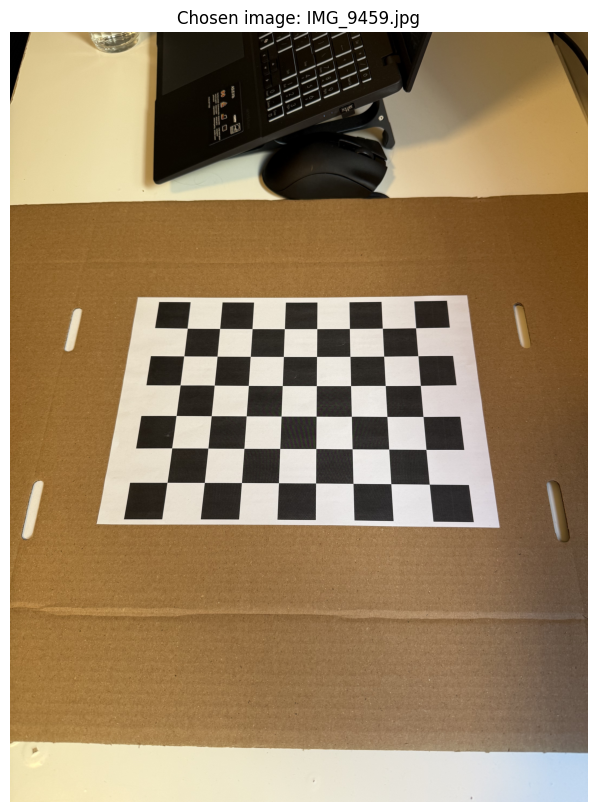

In [3]:
# Discover images
img_paths = expand_image_glob(IMAGES_GLOB)

# Make paths absolute (prevents cv2.imread failures when notebook cwd is not repo root)
img_paths = [str(Path(p).resolve()) for p in img_paths]

print("num images:", len(img_paths))
print("first 5:", img_paths[:5])

assert len(img_paths) > 0, "No images found. Put images under data/chessboard/"

# === Pick a specific image to inspect ===
# Option A: pick by index
IMAGE_INDEX = 0

# Option B: pick by filename (set to None to ignore)
# Example: "IMG_9459.JPG"
IMAGE_BASENAME = None

if IMAGE_BASENAME is not None:
    matches = [p for p in img_paths if os.path.basename(p) == IMAGE_BASENAME]
    assert len(matches) == 1, f"Expected exactly 1 match for {IMAGE_BASENAME}, got {len(matches)}"
    chosen_path = matches[0]
else:
    chosen_path = img_paths[IMAGE_INDEX]

print("chosen:", chosen_path)
print("exists:", os.path.exists(chosen_path))

img0 = imread_any(chosen_path)
if img0 is None:
    # Fallback: pick the first readable image (helps when some files are not decodable by OpenCV)
    for p in img_paths:
        img0 = imread_any(p)
        if img0 is not None:
            chosen_path = p
            break

assert img0 is not None, f"Failed to read any image from glob: {IMAGES_GLOB}"

print("image shape:", img0.shape)

# Show big image (so you can actually see the board)
show(bgr_to_rgb(img0), title=f"Chosen image: {os.path.basename(chosen_path)}", figsize=(12, 10))



chosen corners found: True


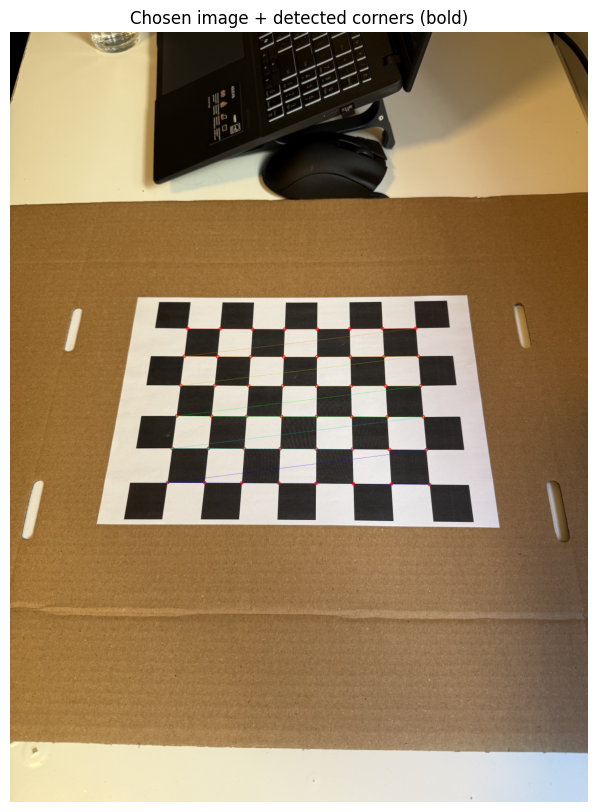

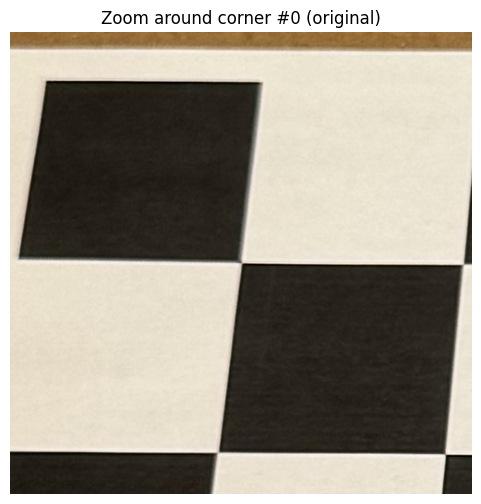

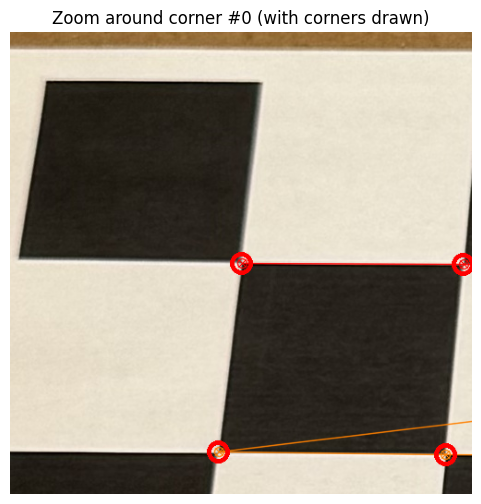

found corners in 40/40 images
failed examples: []


In [4]:
# Step 1: Detect chessboard corners (quality check + clear visualization)

def resize_for_display(img_bgr, max_side=1400):
    h, w = img_bgr.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return img_bgr
    scale = max_side / float(m)
    return cv2.resize(img_bgr, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)


def draw_corners_bold(img_bgr, corners, color=(0, 0, 255)):
    # Draw circles so corners are visible even on huge 4K+ images
    out = img_bgr.copy()
    pts = corners.reshape(-1, 2)
    for (x, y) in pts:
        cv2.circle(out, (int(x), int(y)), 10, color, 3)
    return out


# 1A) Show chosen image with corners (BIG + clear)
gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
found0, corners0 = cv2.findChessboardCorners(gray0, PATTERN_SIZE)
print("chosen corners found:", found0)

if found0 and corners0 is not None:
    vis0 = img0.copy()
    cv2.drawChessboardCorners(vis0, PATTERN_SIZE, corners0, found0)
    vis0 = draw_corners_bold(vis0, corners0)

    vis0_disp = resize_for_display(vis0, max_side=1600)
    show(bgr_to_rgb(vis0_disp), title="Chosen image + detected corners (bold)", figsize=(12, 10))

    # Zoom around the first corner so you can see the black/white stripes clearly
    x0, y0 = corners0.reshape(-1, 2)[0]
    x0, y0 = int(x0), int(y0)
    r = 250
    y1, y2 = max(0, y0 - r), min(img0.shape[0], y0 + r)
    x1, x2 = max(0, x0 - r), min(img0.shape[1], x0 + r)

    zoom_orig = img0[y1:y2, x1:x2].copy()
    zoom_drawn = vis0[y1:y2, x1:x2].copy()

    show(bgr_to_rgb(zoom_orig), title="Zoom around corner #0 (original)", figsize=(6, 6))
    show(bgr_to_rgb(zoom_drawn), title="Zoom around corner #0 (with corners drawn)", figsize=(6, 6))
else:
    print("No corners found in the chosen image. Try another IMAGE_INDEX / IMAGE_BASENAME.")


# 1B) Batch summary: how many images succeed
ok = 0
failed = []

for fn in img_paths:
    img = imread_any(fn)
    if img is None:
        failed.append(fn)
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(gray, PATTERN_SIZE)

    if found and corners is not None:
        ok += 1
    else:
        failed.append(fn)

print(f"found corners in {ok}/{len(img_paths)} images")
print("failed examples:", [os.path.basename(p) for p in failed[:10]])



In [5]:
# Step 2: Calibrate camera intrinsics (K) + distortion (dist)

calib = calibrate_from_chessboard_images(
    img_paths,
    pattern_size=PATTERN_SIZE,
    square_size=SQUARE_SIZE,
    show_detections=False,
)

print("RMS:", calib.rms)
print("K:\n", calib.K)
print("dist:", calib.dist.ravel())
print("image_size (w,h):", calib.image_size)



[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9465.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9466.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9467.jpg
RMS: 1.0178765458507137
K:
 [[4.07022943e+03 0.00000000e+00 2.12880384e+03]
 [0.00000000e+00 4.06843689e+03 2.82687599e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist: [ 1.41175417e-01  5.84059273e-04 -2.07898624e-03 -1.70508134e-03
 -1.52155672e+00]
image_size (w,h): (4284, 5712)


In [6]:
# Step 3: Save + load the calibration

save_calibration_npz(CALIB_OUT, calib)
print("saved:", CALIB_OUT)

calib2 = load_calibration_npz(CALIB_OUT)
print("loaded rms:", calib2.rms)
print("loaded K:\n", calib2.K)
print("loaded dist:", calib2.dist.ravel())



saved: outputs/camera/calibration.npz
loaded rms: 1.0178765058517456
loaded K:
 [[4.07022943e+03 0.00000000e+00 2.12880384e+03]
 [0.00000000e+00 4.06843689e+03 2.82687599e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
loaded dist: [ 1.41175417e-01  5.84059273e-04 -2.07898624e-03 -1.70508134e-03
 -1.52155672e+00]


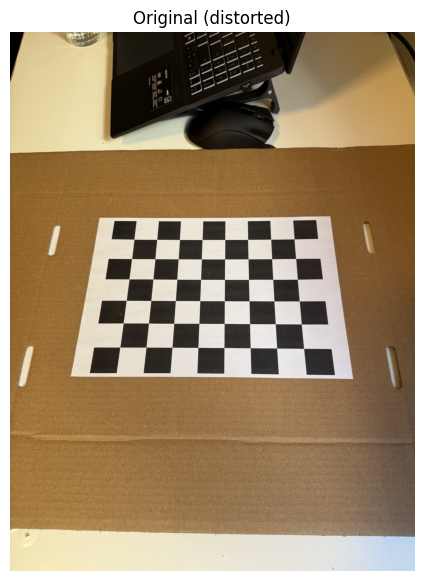

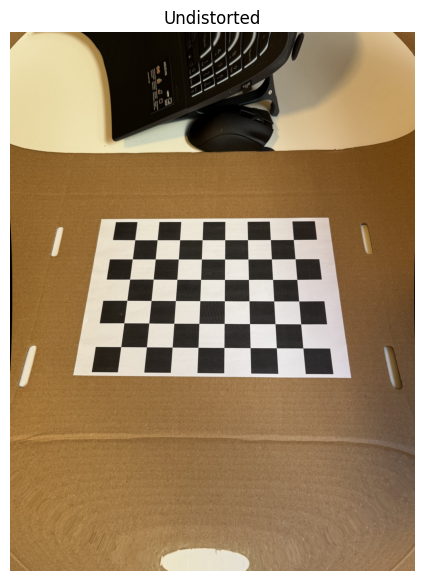

In [7]:
# Step 4 (optional): Undistort a sample image

sample = cv2.imread(img_paths[0])
assert sample is not None
sample_rgb = bgr_to_rgb(sample)

undist = cv2.undistort(sample_rgb, calib2.K, calib2.dist)

show(sample_rgb, title="Original (distorted)")
show(undist, title="Undistorted")



## Part 2B — Planar AR: Render a cube using `solvePnP`

Goal: use the calibrated **K** and **dist** to estimate the pose of your **planar reference image** in a video frame, then render a 3D cube that appears to stand on the plane.

Pipeline (per frame):
- Track the planar marker (Part 1) → homography **H** + 4 corner pixels
- Convert those 4 corners into a pose (**rvec, tvec**) using `cv2.solvePnP`
- Project cube 3D points to image with `cv2.projectPoints`
- Draw the cube

> Important: If your calibration images resolution is different from the video resolution, we must **scale K** to the video size.



In [8]:
from config import Part1Config
from tracker import PlanarTracker

# Inputs for AR cube
VIDEO_PATH = "data/video_part1.mp4"
REFERENCE_PATH = "data/reference.JPG"

# Pick a frame to debug
FRAME_IDX = 0

# World scale for the planar reference.
# We'll set the reference width to 1.0 unit, and height keeps aspect ratio.
PLANE_WIDTH = 1.0

# === Cube size + placement ON the plane ===
# Size is a FRACTION of the plane width.
CUBE_SIZE_FRAC = 0.28        # bigger cube
CUBE_OFFSET_X_FRAC = 0.58    # closer to center + a bit to the right
CUBE_OFFSET_Y_FRAC = 0.48    # a bit lower

# Cube height: usually same as cube size looks nice
CUBE_HEIGHT_FRAC = 1.0

print("video:", VIDEO_PATH)
print("reference:", REFERENCE_PATH)
print("frame_idx:", FRAME_IDX)
print("cube size frac:", CUBE_SIZE_FRAC)
print("cube offset frac (x,y):", (CUBE_OFFSET_X_FRAC, CUBE_OFFSET_Y_FRAC))



video: data/video_part1.mp4
reference: data/reference.JPG
frame_idx: 0
cube size frac: 0.28
cube offset frac (x,y): (0.58, 0.48)


In [9]:
# Load calibration (K, dist)
calib_loaded = load_calibration_npz(CALIB_OUT)
K_calib = calib_loaded.K.copy()
dist = calib_loaded.dist.copy()
calib_size = calib_loaded.image_size  # (w,h)
print("calib image_size (w,h):", calib_size)
print("K (calib):\n", K_calib)
print("dist:", dist.ravel())


def scale_K_to_new_size(K, from_size_wh, to_size_wh):
    """Scale intrinsics K when resizing images from from_size to to_size."""
    from_w, from_h = from_size_wh
    to_w, to_h = to_size_wh
    sx = to_w / float(from_w)
    sy = to_h / float(from_h)
    K2 = K.copy().astype(np.float64)
    K2[0, 0] *= sx  # fx
    K2[1, 1] *= sy  # fy
    K2[0, 2] *= sx  # cx
    K2[1, 2] *= sy  # cy
    return K2



calib image_size (w,h): (4284, 5712)
K (calib):
 [[4.07022943e+03 0.00000000e+00 2.12880384e+03]
 [0.00000000e+00 4.06843689e+03 2.82687599e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist: [ 1.41175417e-01  5.84059273e-04 -2.07898624e-03 -1.70508134e-03
 -1.52155672e+00]


ref (w,h): (1200, 1711) aspect: 1.4258333333333333
frame (w,h): (1080, 1920)
Scaled K to match video resolution
K (used):
 [[1.02610826e+03 0.00000000e+00 5.36673237e+02]
 [0.00000000e+00 1.36754181e+03 9.50210418e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


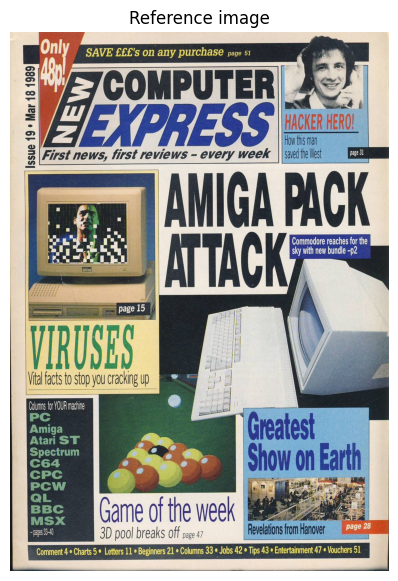

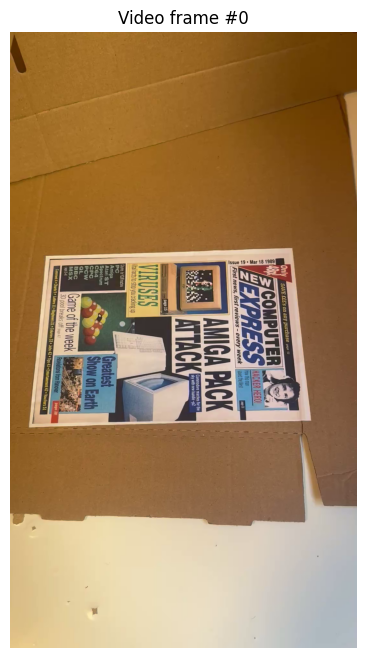

In [10]:
# Load reference + a single video frame
ref_bgr = cv2.imread(REFERENCE_PATH)
assert ref_bgr is not None, f"Failed to read {REFERENCE_PATH}"
ref_h, ref_w = ref_bgr.shape[:2]
ref_aspect = ref_h / float(ref_w)

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Failed to open {VIDEO_PATH}"

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_IDX)
ok, frame_bgr = cap.read()
cap.release()
assert ok and frame_bgr is not None, f"Failed to read frame {FRAME_IDX}"

frame_h, frame_w = frame_bgr.shape[:2]
print("ref (w,h):", (ref_w, ref_h), "aspect:", ref_aspect)
print("frame (w,h):", (frame_w, frame_h))

# Scale K if needed
K = K_calib
if calib_size != (frame_w, frame_h):
    K = scale_K_to_new_size(K_calib, calib_size, (frame_w, frame_h))
    print("Scaled K to match video resolution")

print("K (used):\n", K)

show(bgr_to_rgb(ref_bgr), title="Reference image", figsize=(10, 7))
show(bgr_to_rgb(frame_bgr), title=f"Video frame #{FRAME_IDX}", figsize=(12, 8))



dbg: {'good': 1734, 'inliers': 1350}


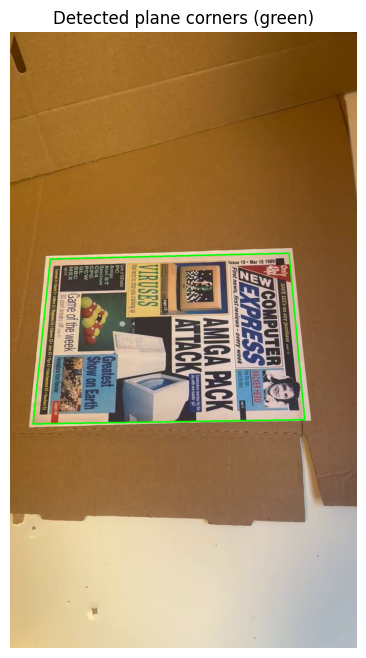

In [11]:
# Track the planar marker on this frame (Part 1 tracker)
tracker = PlanarTracker(ref_bgr, Part1Config())
H, corners, dbg = tracker.track(frame_bgr)
print("dbg:", dbg)

vis = frame_bgr.copy()
if corners is not None:
    cv2.polylines(vis, [corners.astype(int)], True, (0, 255, 0), 3)

show(bgr_to_rgb(vis), title="Detected plane corners (green)", figsize=(12, 8))

assert corners is not None, "No plane detected in this frame. Try another FRAME_IDX."


In [12]:
# SolvePnP using the 4 plane corners
# Define the reference plane 3D coordinates (Z=0). We normalize width to PLANE_WIDTH.
plane_w = float(PLANE_WIDTH)
plane_h = float(PLANE_WIDTH) * ref_aspect

obj_pts = np.array(
    [
        [0.0, 0.0, 0.0],
        [plane_w, 0.0, 0.0],
        [plane_w, plane_h, 0.0],
        [0.0, plane_h, 0.0],
    ],
    dtype=np.float32,
)

img_pts = corners.reshape(-1, 2).astype(np.float32)

ok_pnp, rvec, tvec = cv2.solvePnP(
    obj_pts,
    img_pts,
    K,
    dist,
    flags=cv2.SOLVEPNP_ITERATIVE,
)

print("solvePnP ok:", ok_pnp)
print("rvec:\n", rvec)
print("tvec:\n", tvec)
assert ok_pnp



solvePnP ok: True
rvec:
 [[-0.53562453]
 [ 0.54104969]
 [ 1.48644079]]
tvec:
 [[ 0.62823766]
 [-0.45037629]
 [ 2.31869647]]


cube_size: 0.28 cube_h: 0.28
cube origin (x0,y0): (np.float64(0.58), np.float64(0.6843999999999999))


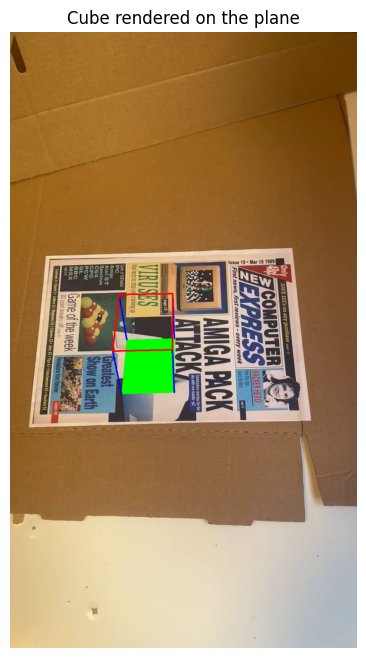

In [13]:
# Define a SMALL cube in 3D and project it to the image
# Convention: cube "stands" on the plane. We use negative Z to lift it out of the plane.

cube_size = float(CUBE_SIZE_FRAC) * plane_w
cube_h = float(CUBE_HEIGHT_FRAC) * cube_size

# Place it somewhere inside the plane
x0 = float(CUBE_OFFSET_X_FRAC) * plane_w
y0 = float(CUBE_OFFSET_Y_FRAC) * plane_h

# Keep cube inside the plane bounds
x0 = np.clip(x0, 0.0, plane_w - cube_size)
y0 = np.clip(y0, 0.0, plane_h - cube_size)

cube_3d = np.array(
    [
        [x0, y0, 0.0],
        [x0 + cube_size, y0, 0.0],
        [x0 + cube_size, y0 + cube_size, 0.0],
        [x0, y0 + cube_size, 0.0],
        [x0, y0, -cube_h],
        [x0 + cube_size, y0, -cube_h],
        [x0 + cube_size, y0 + cube_size, -cube_h],
        [x0, y0 + cube_size, -cube_h],
    ],
    dtype=np.float32,
)

imgpts, _ = cv2.projectPoints(cube_3d, rvec, tvec, K, dist)
imgpts = imgpts.reshape(-1, 2)

print("cube_size:", cube_size, "cube_h:", cube_h)
print("cube origin (x0,y0):", (x0, y0))


def draw_cube(img_bgr, imgpts2d):
    img = img_bgr.copy()
    pts = np.int32(imgpts2d).reshape(-1, 2)

    # base (green filled)
    img = cv2.drawContours(img, [pts[:4]], -1, (0, 255, 0), -1)

    # pillars (blue)
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(pts[i]), tuple(pts[j]), (255, 0, 0), 3)

    # top (red outline)
    img = cv2.drawContours(img, [pts[4:]], -1, (0, 0, 255), 3)
    return img

cube_vis = draw_cube(frame_bgr, imgpts)
show(bgr_to_rgb(cube_vis), title="Cube rendered on the plane", figsize=(12, 8))



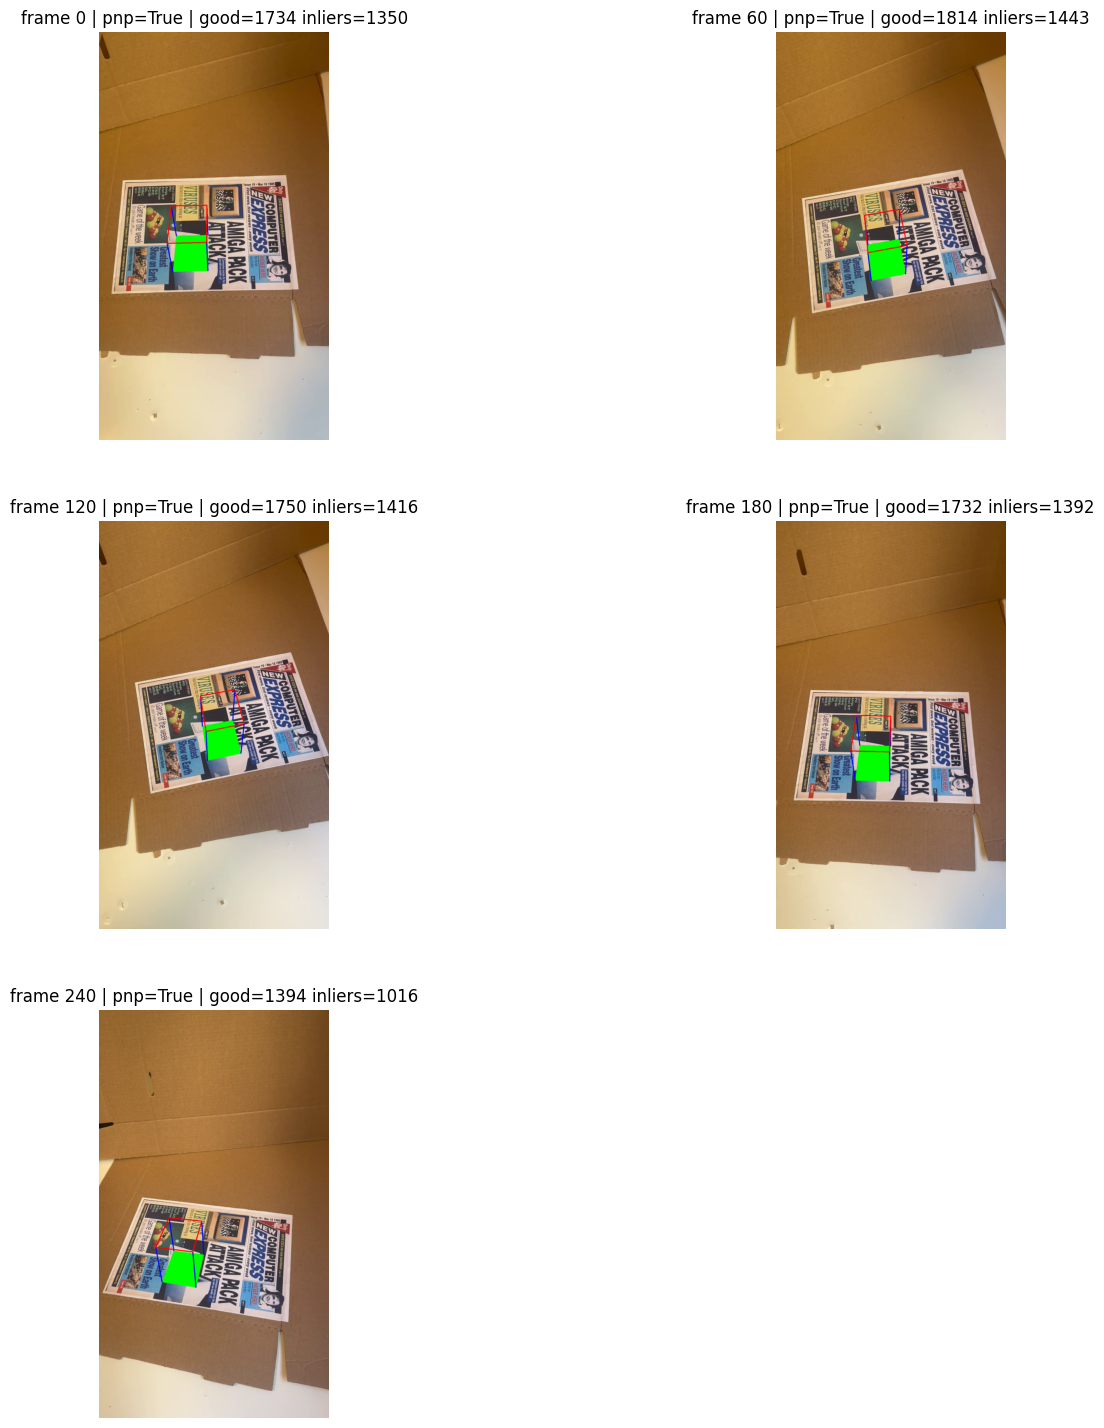

shown frames: [0, 60, 120, 180, 240]


In [14]:
# Show the cube on a few specific frames (no video export)

# Option A: choose exact frame indices
SAMPLE_FRAME_IDXS = [0, 60, 120, 180, 240]

# Option B: build indices by (start, step, count)
# START_FRAME = 0
# STEP = 60
# COUNT = 6
# SAMPLE_FRAME_IDXS = [START_FRAME + i * STEP for i in range(COUNT)]

# Reuse tracking params
tracker_vid = PlanarTracker(ref_bgr, Part1Config())

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Failed to open {VIDEO_PATH}"

out_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Ensure K matches the actual video size
K_vid = K_calib
if calib_size != (out_w, out_h):
    K_vid = scale_K_to_new_size(K_calib, calib_size, (out_w, out_h))

results = []  # list of (frame_idx, img_bgr, dbg, ok_pnp)

for fidx in SAMPLE_FRAME_IDXS:
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(fidx))
    ok, frame = cap.read()
    if not ok or frame is None:
        print("failed to read frame:", fidx)
        continue

    H, corners, dbg = tracker_vid.track(frame)

    out = frame
    ok_pnp = False
    if corners is not None:
        img_pts = corners.reshape(-1, 2).astype(np.float32)
        ok_pnp, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K_vid, dist, flags=cv2.SOLVEPNP_ITERATIVE)
        if ok_pnp:
            imgpts, _ = cv2.projectPoints(cube_3d, rvec, tvec, K_vid, dist)
            out = draw_cube(out, imgpts.reshape(-1, 2))

    results.append((fidx, out, dbg, ok_pnp))

cap.release()

# Display results in a grid
n = len(results)
cols = 2
rows = int(np.ceil(n / cols))
plt.figure(figsize=(16, 6 * rows))

for i, (fidx, img, dbg, ok_pnp) in enumerate(results):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    title = f"frame {fidx} | pnp={ok_pnp} | good={dbg.get('good')} inliers={dbg.get('inliers')}"
    plt.title(title)

    # resize for display
    disp = img
    if max(img.shape[0], img.shape[1]) > 1600:
        disp = resize_for_display(img, max_side=1600)
    plt.imshow(bgr_to_rgb(disp))

plt.show()
print("shown frames:", [r[0] for r in results])

